In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import statsmodels
from collections import Counter
import cpi
import ast
import json
import datetime
from sklearn.decomposition import PCA
from collections import Counter

In [5]:
# Source: https://stackoverflow.com/questions/43214978/seaborn-barplot-displaying-values
def show_values_on_bars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

In [31]:
dataset_original = pd.read_csv('./tmdb-box-office-prediction/train.csv')
dataset_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3000 non-null   int64  
 1   belongs_to_collection  604 non-null    object 
 2   budget                 3000 non-null   int64  
 3   genres                 2993 non-null   object 
 4   homepage               946 non-null    object 
 5   imdb_id                3000 non-null   object 
 6   original_language      3000 non-null   object 
 7   original_title         3000 non-null   object 
 8   overview               2992 non-null   object 
 9   popularity             3000 non-null   float64
 10  poster_path            2999 non-null   object 
 11  production_companies   2844 non-null   object 
 12  production_countries   2945 non-null   object 
 13  release_date           3000 non-null   object 
 14  runtime                2998 non-null   float64
 15  spok

In [32]:
dataset = dataset_original.copy()

def fix_date(date):
    x = pd.to_datetime(date, format="%m/%d/%y")
    if x.year > 2020:
        year = x.year - 100
    else:
        year = x.year
    return datetime.datetime(year,x.month,x.day)

dataset["release_date"] = dataset_original["release_date"].apply(fix_date)

def adjust_price_to_inflation(price, date):
    return int(cpi.inflate(price, date.year))

dataset["budget"] = dataset.apply(lambda x: adjust_price_to_inflation(x["budget"], x["release_date"]), axis=1)
dataset["revenue"] = dataset.apply(lambda x: adjust_price_to_inflation(x["revenue"], x["release_date"]), axis=1)

In [11]:
print("Oldest: ", dataset["release_date"].min())
print("Newest: ", dataset["release_date"].max())

Oldest:  1921-01-21 00:00:00
Newest:  2017-07-20 00:00:00


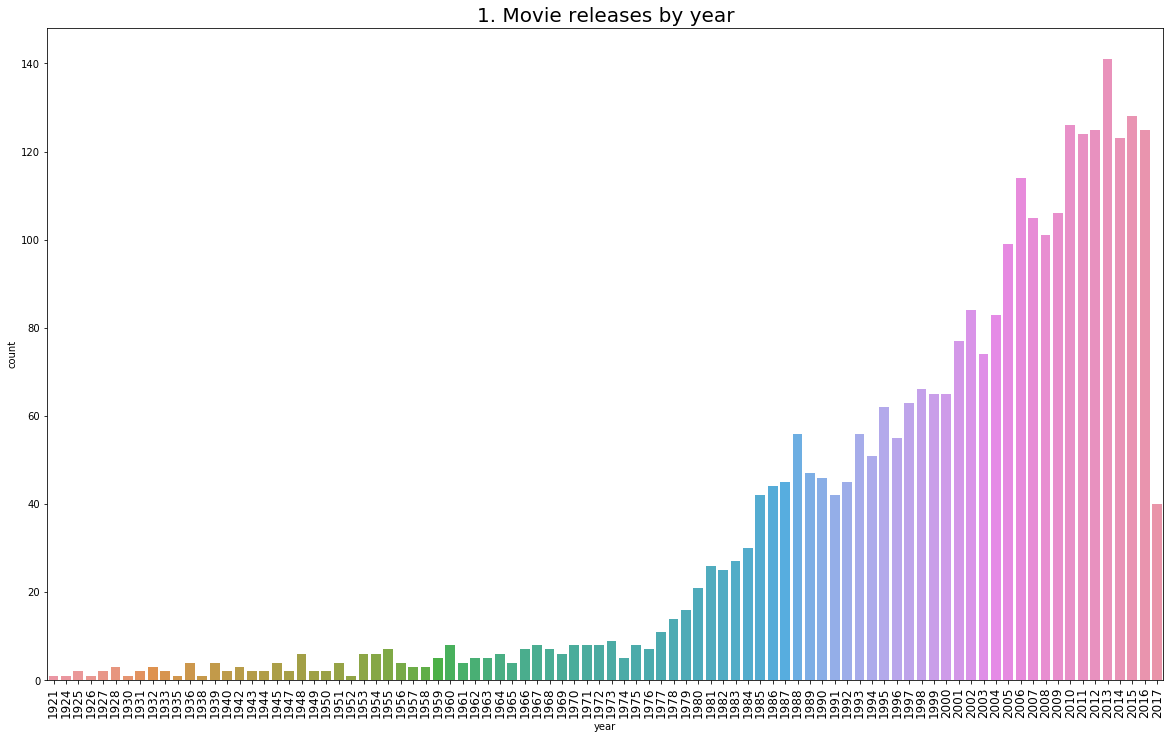

In [12]:
plt.figure(figsize=(20,12))
sns.countplot(dataset['release_date'].dt.year.sort_values())
plt.title("1. Movie releases by year",fontsize=20)
plt.xticks(fontsize=12,rotation=90)
plt.xlabel("year")
plt.show()

Nasz zbiór danych posiada więcej filmów z lat współczesnych

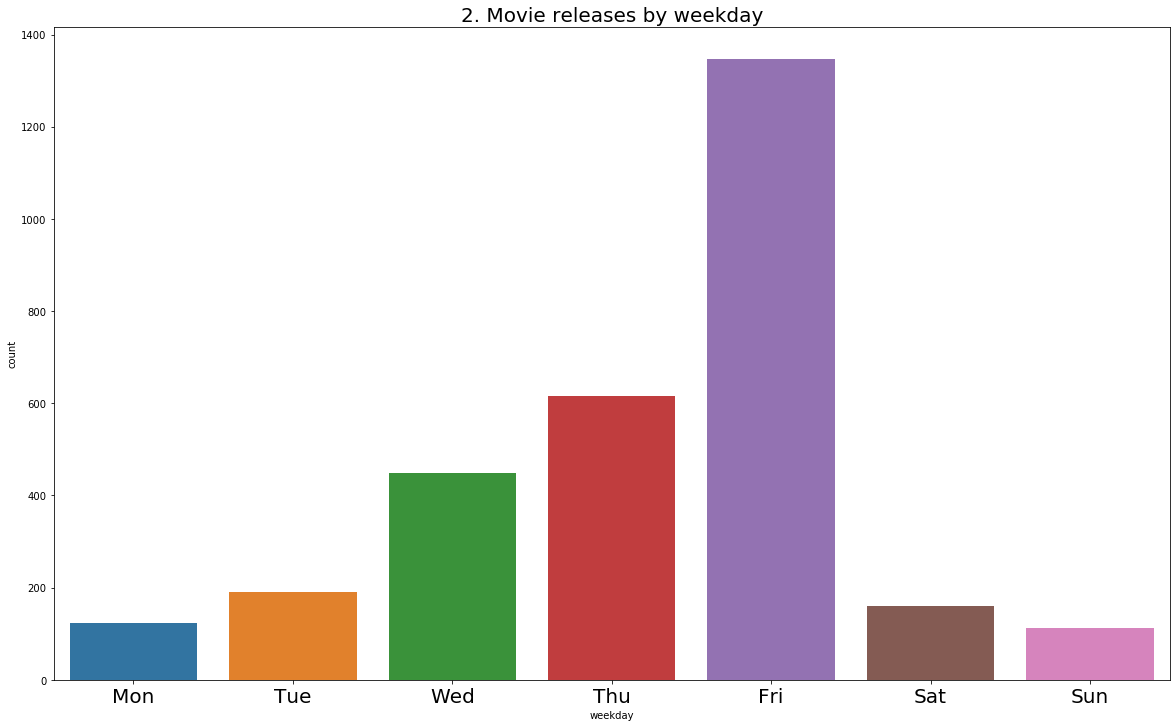

In [13]:
plt.figure(figsize=(20,12))
sns.countplot(dataset['release_date'].dt.weekday.sort_values())
plt.title("2. Movie releases by weekday",fontsize=20)
loc, _ = plt.xticks()
loc, labels = loc, ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]
plt.xticks(loc, labels,fontsize=20)
plt.xlabel("weekday")
plt.show()

Najwięcej filmów wydaje się w dni przed weekendem - środę, czwartek i piątek, najmniej natomiast w poniedziałek, wtorek, sobotę i niedzielę

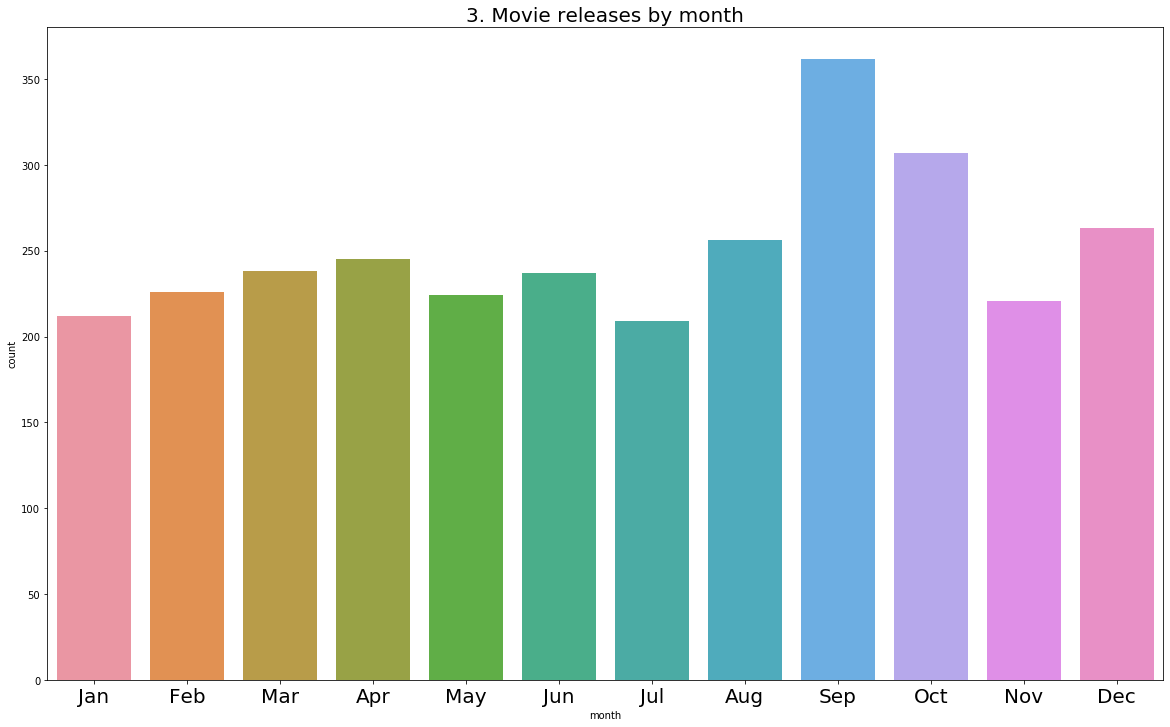

In [14]:
plt.figure(figsize=(20,12))
sns.countplot(dataset['release_date'].dt.month.sort_values())
plt.title("3. Movie releases by month",fontsize=20)
loc, _ = plt.xticks()
loc, labels = loc, ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
plt.xticks(loc, labels,fontsize=20)
plt.xlabel("month")
plt.show()

Ilość filmów wydawanych w ciągu roku jest podobna, najwięcej filmów zostało wydanych we wrześniu a najmniej w lipcu

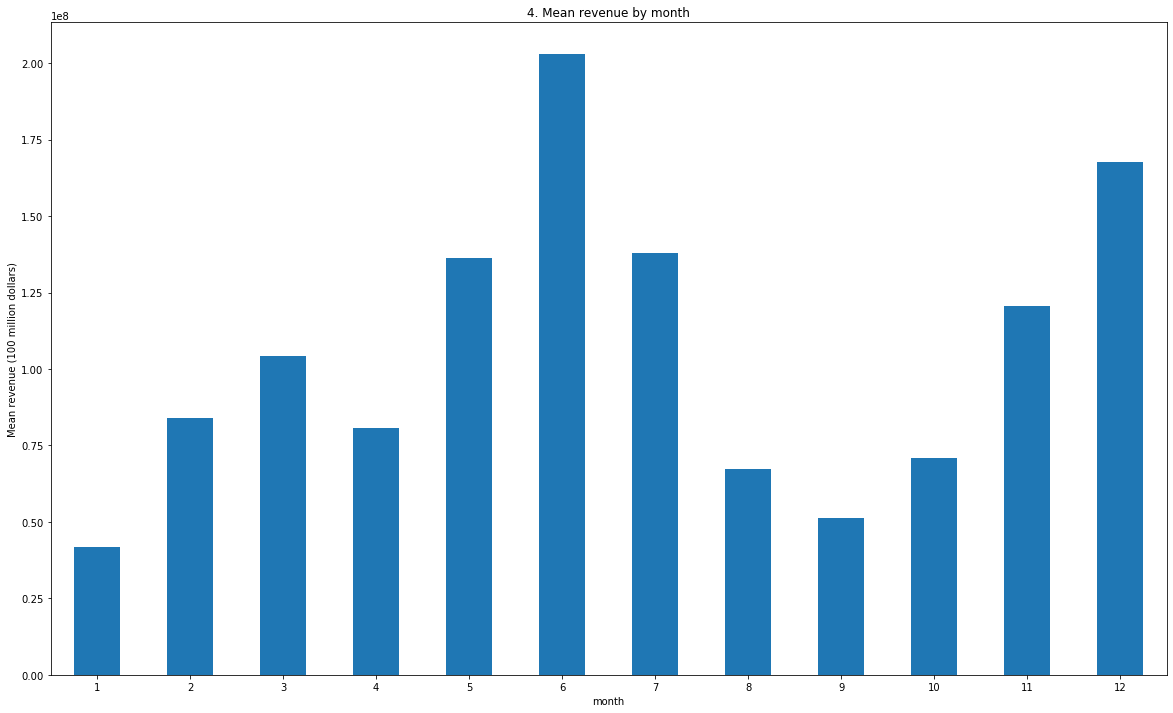

In [15]:
plt.figure(figsize=(20,12))
dataset.groupby(dataset["release_date"].dt.month).agg('mean')['revenue'].plot(kind='bar',rot=0)
plt.ylabel('Mean revenue (100 million dollars)')
plt.title("4. Mean revenue by month")
plt.xlabel("month")
plt.show()

Średnio najwięcej przychodów przynoszą filmy wydane w czerwcu a najmniej filmy wydane w styczniu

In [16]:
import ast
dict_columns = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

def text_to_dict(df):
    for column in dict_columns:
        df[column] = df[column].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x) )
    return df
        
dfx = text_to_dict(dataset)
temp = dataset.copy()
for col in dict_columns:
       temp[col]=dfx[col]

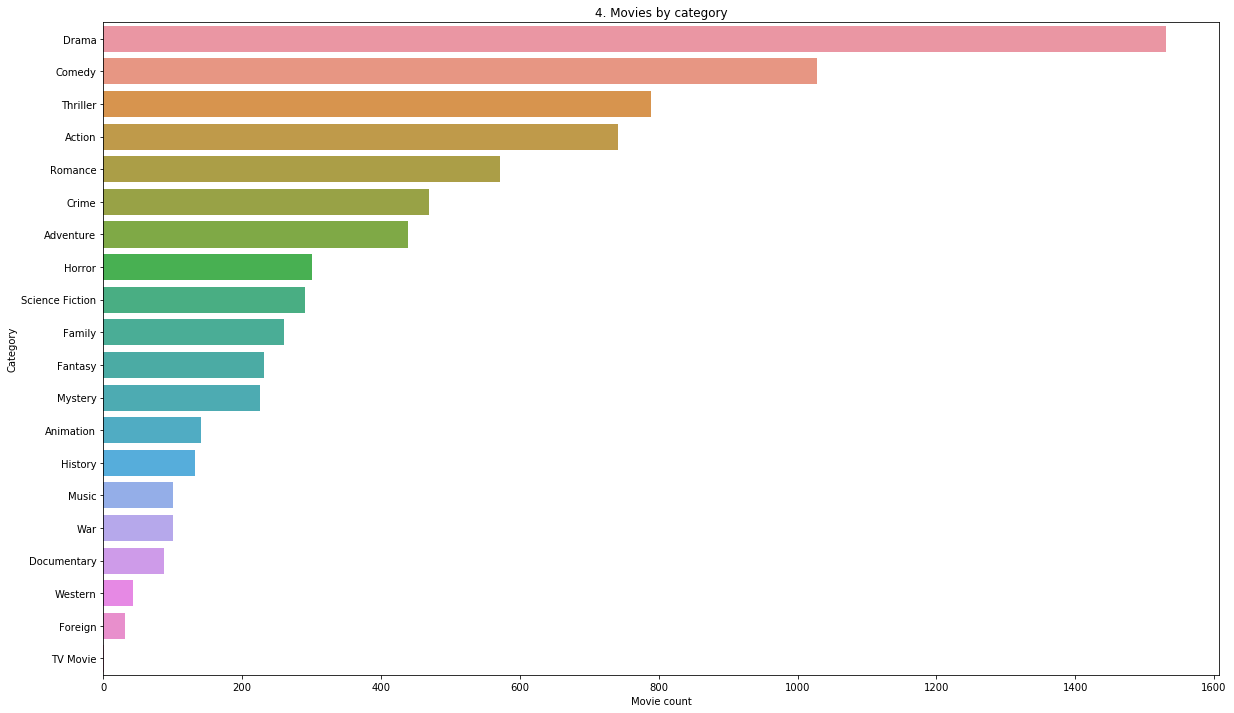

In [17]:
plt.figure(figsize=(20,12))
genre=temp['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else [])
count=Counter([i for j in genre for i in j]).most_common(20)
sns.barplot([val[1] for val in count],[val[0] for val in count])
plt.title("4. Movies by category")
plt.xlabel("Movie count")
plt.ylabel("Category")
plt.show()

Najwięcej wydanych zostało dramatów a najmniej westernów

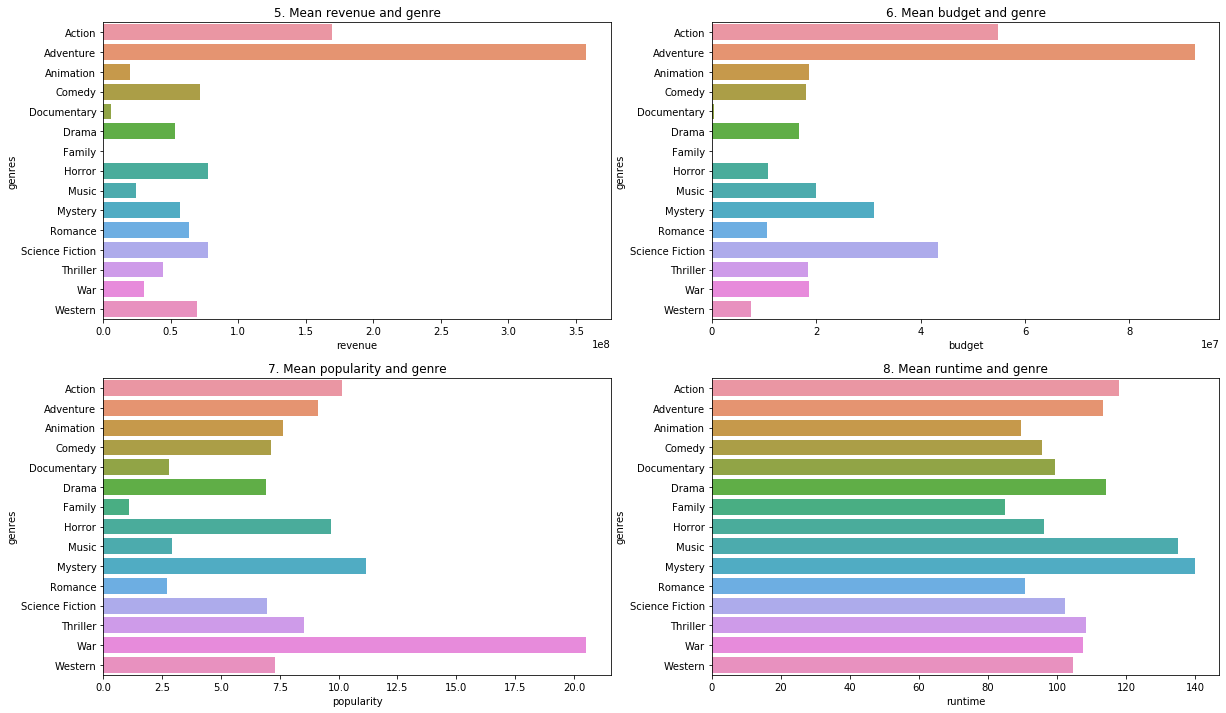

In [18]:
genres=dataset.loc[dataset['genres'].str.len()==1][['genres','revenue','budget','popularity','runtime']].reset_index(drop=True)
genres['genres']=genres.genres.apply(lambda x :x[0]['name'])
genres=genres.groupby(genres.genres).agg('mean')
plt.figure(figsize=(20,12))
plt.subplot(2,2,1)
plt.title("5. Mean revenue and genre")
sns.barplot(genres['revenue'],genres.index)

plt.subplot(2,2,2)
plt.title("6. Mean budget and genre")
sns.barplot(genres['budget'],genres.index)

plt.subplot(2,2,3)
plt.title("7. Mean popularity and genre")
sns.barplot(genres['popularity'],genres.index)

plt.subplot(2,2,4)
plt.title("8. Mean runtime and genre")
sns.barplot(genres['runtime'],genres.index)
plt.show()

Średnie największe przychody przynoszą filmy przygodowe oraz filmy akcji, posiadają one również największe średnie budżety. 

Średnie najmniejsze przychody przynoszą filmy dokumentalne, posiadają one również średnio najmniejszy budżet.

Średnio największą popularnością cieszą się filmy wojenne a najmniejszą filmy familijne.

Średnio najdłuższe są filmy kryminalne i musicale a najkrótsze filmy familijne.

In [19]:
genres

,revenue,budget,popularity,runtime
genres,,,,
Action,1.692047e+08,5.481114e+07,10.134257,117.882353
Adventure,3.578080e+08,9.259161e+07,9.102847,113.333333
Animation,1.991433e+07,1.859341e+07,7.621484,89.500000
Comedy,7.168665e+07,1.795529e+07,7.130002,95.637838
Documentary,5.477242e+06,3.886612e+05,2.811771,99.250000
Drama,5.300513e+07,1.666786e+07,6.931788,114.271698
Family,1.200000e+02,0.000000e+00,1.073743,85.000000
Horror,7.726301e+07,1.073364e+07,9.672260,96.225806
Music,2.440192e+07,1.983108e+07,2.905457,135.000000


Actors number:  38588


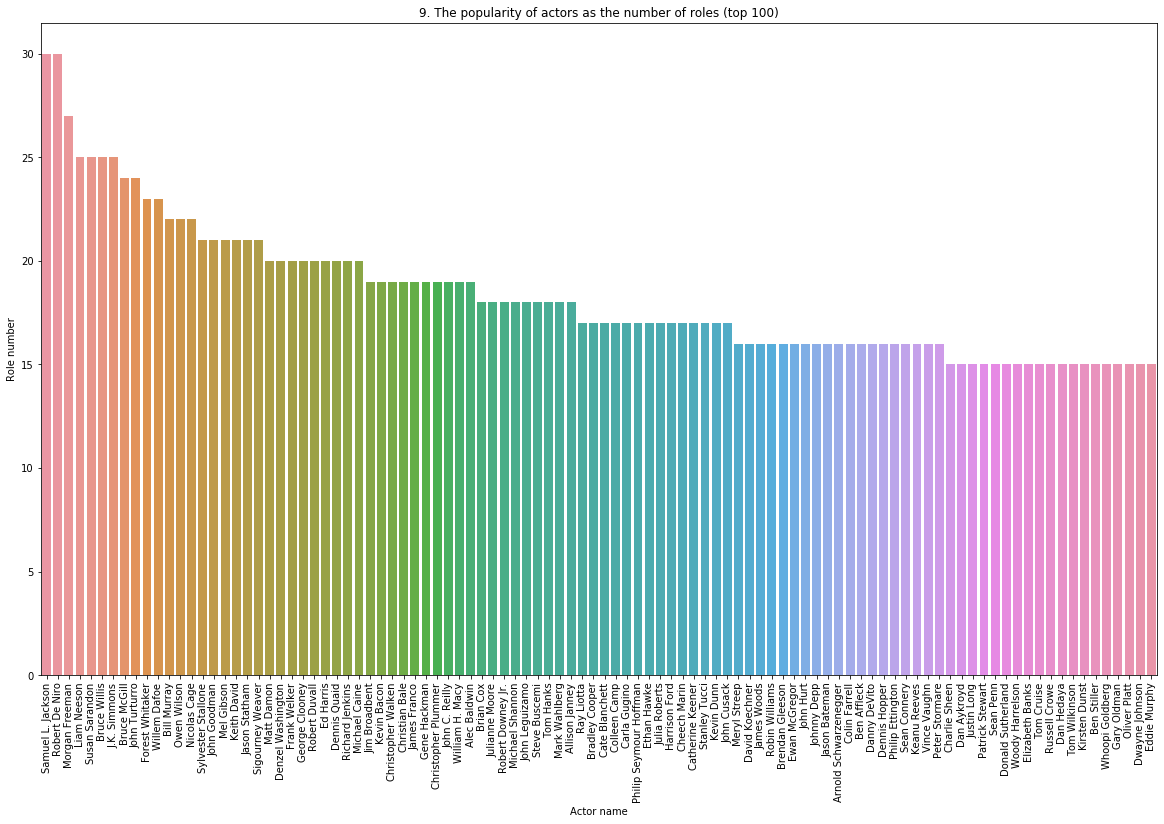

In [42]:
# popularity of an actor expressed as number of films
n = 100
actorMovieDataset = dataset[['id','cast']].copy()
actorMovieDataset['cast'] = actorMovieDataset['cast'].apply(lambda x: {} if pd.isna(x) else [x.get('name') for x in ast.literal_eval(x)])
actorMovieDataset = actorMovieDataset.explode('cast').reset_index(drop=True)
actorMovieDataset = actorMovieDataset.groupby(['cast']).size().reset_index(name='count').sort_values('count', ascending=False)
print("Actors number: ", actorMovieDataset.shape[0])

plt.figure(figsize=(20,12))
sns.barplot(actorMovieDataset['cast'].head(n), actorMovieDataset['count'].head(n))
plt.title("9. The popularity of actors as the number of roles (top {0})".format(n))
plt.xlabel("Actor name")
plt.ylabel("Role number")
plt.xticks(rotation=90)

plt.show()

Liczba aktorów w zbiorze danych wynosi 38588. Pokazanie na jendym wykresie liczby angaży dla wszystkich aktorów jest niewykonalne.

Najpopularniejszymi aktorami są Samuel L. Jackson oraz Robert De Niro. Obaj panowie zagrali w 30 filmach z naszego zbioru danych.

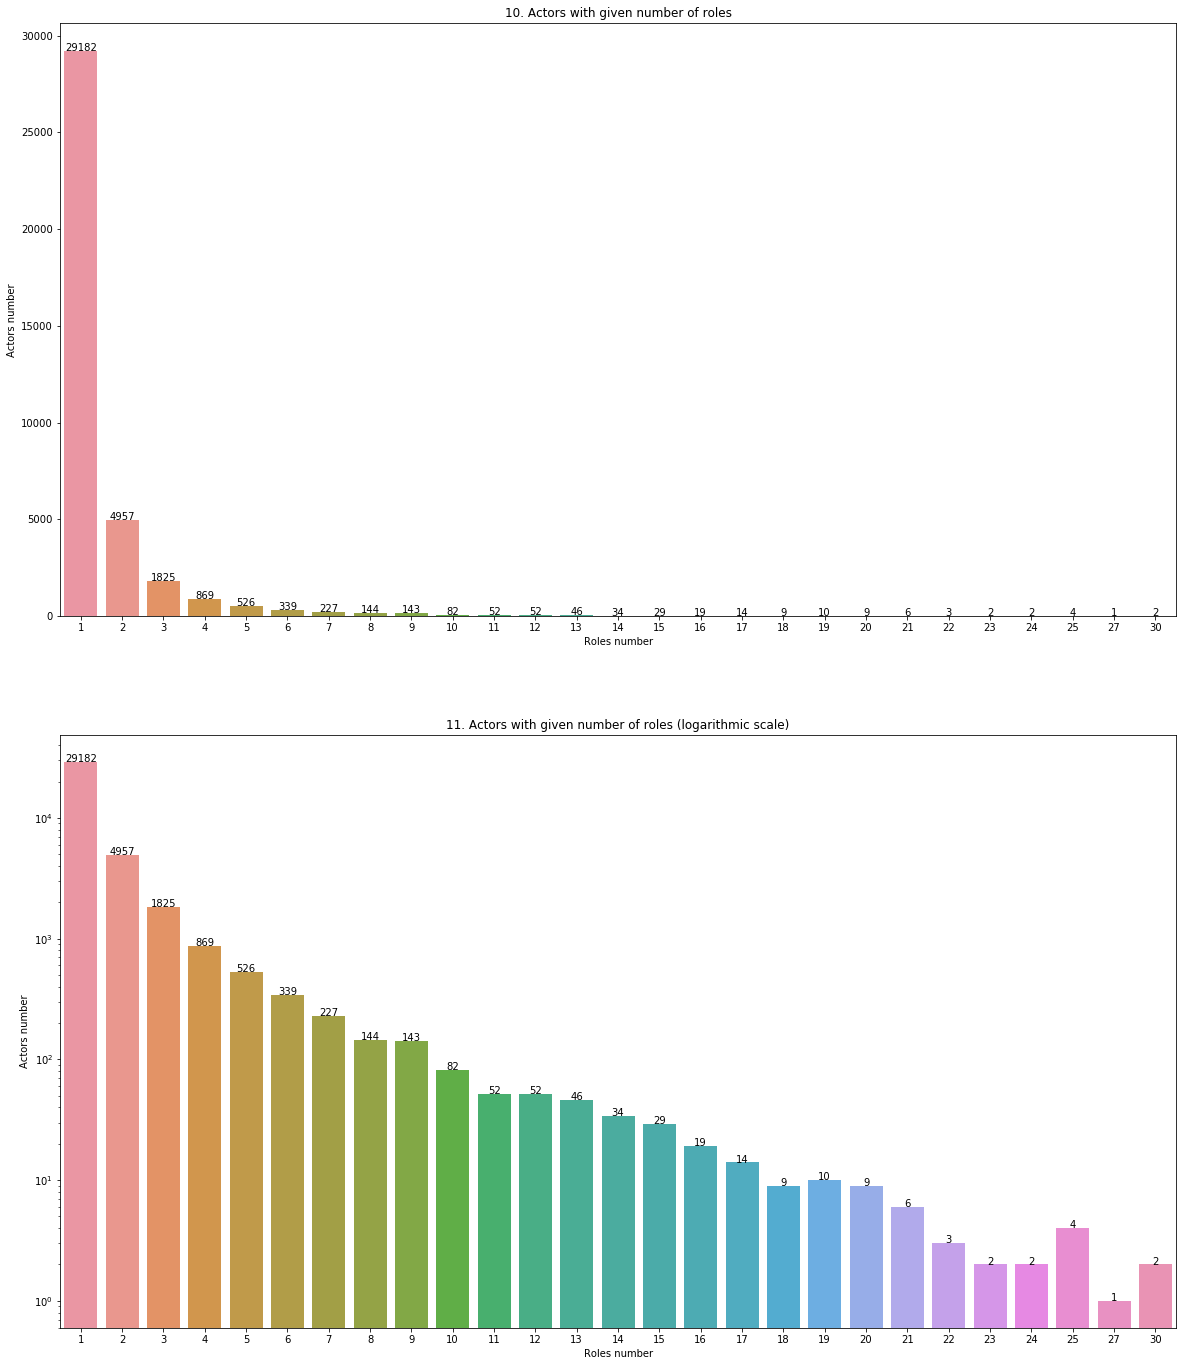

In [43]:
# number of actors with concrette role number
actorMovieDataset = dataset_original[['id','cast']].copy()
actorMovieDataset['cast'] = actorMovieDataset['cast'].apply(lambda x: {} if pd.isna(x) else [x.get('name') for x in ast.literal_eval(x)])
actorMovieDataset = actorMovieDataset.explode('cast').reset_index(drop=True)
actorMovieDataset = actorMovieDataset.groupby(['cast']).size().reset_index(name='count').sort_values('count', ascending=False)
actorMovieRolesDataset = actorMovieDataset.groupby(['count']).size().reset_index(name='actors_with_given_role_number')
x = actorMovieRolesDataset['count']
y = actorMovieRolesDataset['actors_with_given_role_number']

plt.figure(figsize=(20,24))
plt.subplot(2,1,1)
snbp = sns.barplot(x='count',y='actors_with_given_role_number',data=actorMovieRolesDataset)
show_values_on_bars(snbp, "v", 0.5)
plt.title("10. Actors with given number of roles")
plt.xlabel("Roles number")
plt.ylabel("Actors number")

plt.subplot(2,1,2)
snbp = sns.barplot(x='count',y='actors_with_given_role_number',data=actorMovieRolesDataset)
show_values_on_bars(snbp, "v", 0.5)
snbp.set_yscale('log')
plt.title("11. Actors with given number of roles (logarithmic scale)")
plt.xlabel("Roles number")
plt.ylabel("Actors number")

plt.show()

Dominujący są aktorzy, którzy zagrali w jednym filmie. Liczba aktorów, która zagrała tylko w jednym filmie stanowi ok. 75.6% wszystkich aktorów z zbiorze danych.

Wśród aktorów wysoką popularność przejawiającą się, jako duża liczba angaży, wykazuje wąskie grono osób. Tylko 376 aktorów zagrało w co najmniej 10 filmach, co stanowi zaledwie ok. 0.9%.

Liczba aktorów posiadających daną liczbę angazy maleje wykładniczo wraz z rosnącą liczbą zagranych ról.